In [1]:
import math
from math import pow, ceil, floor
import numpy as np
from numpy import sin, cos, pi, power, sqrt, log, log2
import matplotlib.pyplot as plt
import cv2
import sys

In [2]:
# Set basic "global" parameters
A = 2500
w_x = 2
w_y = 7
sample_size = 1024
B_low = 5000
B_high = 50000

In [3]:
# part b assitance function
def get_sample_image(n_x,n_y):
    image = np.empty([n_y,n_x])
    for i in range(n_y):
        for j in range(n_x):
            x_l, x_h = float(j)/n_x, float(j+1)/n_x
            y_l, y_h = float(i)/n_y, float(i+1)/n_y
            sin_calc = sin(2*pi*w_x*x_h)-sin(2*pi*w_x*x_l)
            cos_calc = (cos(2*pi*w_y*y_h)-cos(2*pi*w_y*y_l))
            image[i,j] = (n_x*n_y*A*cos_calc*sin_calc)/(pow(2*pi,2)*w_x*w_y)
    return image

In [4]:
# part b
image = get_sample_image(sample_size,sample_size)
image_show = ((image/(2*A)) + 0.5).astype("float32")
cv2.imshow('image part b', image_show)
cv2.waitKey()

-1

In [5]:
# part c assistance function

def get_der_matrix_by_both_axis(image):
    
    y_len,x_len = image.shape
    der_matrix_x = np.empty(image.shape)
    der_matrix_y = np.empty(image.shape)
    
    for i in range(y_len):
        for j in range(x_len):
            der_matrix_y[i,j] = image[(i+1)%y_len,j] - image[i,j]
            der_matrix_x[i,j] = image[i,(j+1)%x_len] - image[i,j]
            
    der_matrix_x = der_matrix_x * x_len
    der_matrix_y = der_matrix_y * y_len
    
    return der_matrix_x, der_matrix_y

def calc_energy(image):
    y_len,x_len = image.shape
    area = x_len * y_len
    der_matrix_x, der_matrix_y = get_der_matrix_by_both_axis(image)
    hor_der_energy = np.sum(power(der_matrix_x, 2)/area)
    ver_der_energy = np.sum(power(der_matrix_y, 2)/area)
    return hor_der_energy, ver_der_energy

In [8]:
# part c
phi_l, phi_h = np.amin(image),np.amax(image)
horizontal_der, vertical_der = calc_energy(image)
delta_phi = phi_h - phi_l
print("Value Range: "+str(int(delta_phi)))
print("Horizontal-Derivative energy: " + str(horizontal_der))
print("Vertical-Derivative energy: " + str(vertical_der))

Value Range: 4999
Horizontal-Derivative energy: 246695987.52134135
Vertical-Derivative energy: 3021599202.9528975


In [9]:
# part e assistance function
def calc_mse(x_der_energy, y_der_energy, delta_phi, b, N_x, N_y):
    try:
        x_calc = (x_der_energy) / (12*(pow(N_x,2)))
        y_calc = (y_der_energy) / (12*(pow(N_y,2))) 
        range_calc = (pow(delta_phi,2)) / (12*(pow(2,(2*b))))
        return  x_calc + y_calc + range_calc
    except:
        return sys.maxsize


def calc_ny(budget, b, nx):
    return floor(budget/(b*nx))


def get_iterates(b, N_x, budget):
    iterations = []
    round_down_b, round_down_nx = floor(b), floor(N_x)
    round_up_b, round_up_nx = ceil(b), ceil(N_x)
    iterations.append([round_down_b, round_down_nx, calc_ny(budget, round_down_b, round_down_nx)])
    iterations.append([round_down_b, round_up_nx, calc_ny(budget,round_down_b,round_up_nx)])
    iterations.append([round_up_b, round_up_nx, calc_ny(budget,round_up_b,round_up_nx)])
    iterations.append([round_up_b, round_down_nx, calc_ny(budget,round_up_b,round_down_nx)])
    return iterations


def get_initial_params(x_der_energy, y_der_energy, delta_phi, bit_budgets):
    b = log2((pow(delta_phi,2)*bit_budgets * log(2)) / sqrt(x_der_energy * y_der_energy)) / 2
    N_x = sqrt((sqrt(x_der_energy)*bit_budgets) / (sqrt(y_der_energy)*b))
    iterables = get_iterates(b, N_x, bit_budgets)
    return b, N_x, iterables
    

def get_bit_allocation(x_der_energy, y_der_energy, delta_phi, bit_budgets):
    best_MSE = sys.maxsize
    b,N_x, iterables = get_initial_params(x_der_energy, y_der_energy, delta_phi, bit_budgets)
    for iter in iterables:
        curr_b,curr_N_x,curr_N_y = iter
        curr_MSE = calc_mse(x_der_energy, y_der_energy, delta_phi, curr_b, curr_N_x, curr_N_y)
        if curr_MSE < best_MSE:
            b,N_x,N_y = curr_b,curr_N_x,curr_N_y
            best_MSE = curr_MSE
    return [b, N_x, N_y]

In [11]:
# part e

numeric_low = get_bit_allocation(horizontal_der, vertical_der, delta_phi, B_low)
numeric_high = get_bit_allocation(horizontal_der, vertical_der, delta_phi, B_high)
print("B low:")
print("b = " + str(numeric_low[0]) + ",  N_x = " + str(numeric_low[1]) + ",  N_y = " + str(numeric_low[2]))
print("B high:")
print("b = " + str(numeric_high[0]) + ",  N_x = " + str(numeric_high[1]) + ",  N_y = " + str(numeric_high[2]))

B low:
b = 3,  N_x = 21,  N_y = 79
B high:
b = 5,  N_x = 54,  N_y = 185


In [12]:
# part f implementation
def scan_find_best_bit_allocation(x_der_energy, y_der_energy, delta_phi, bit_budgets):
    best_MSE = sys.maxsize
    for b in np.arange(1, bit_budgets, 1):
        for nx in np.arange(1,floor(float(bit_budgets)/b)):
            ny = calc_ny(bit_budgets, b,nx)
            curr_MSE = calc_mse(x_der_energy, y_der_energy, delta_phi, b, nx, ny)
            if curr_MSE < best_MSE:
                best_b, best_N_x, best_N_y= b,nx,ny
                best_MSE = curr_MSE
    return [best_b, best_N_x, best_N_y]

In [13]:
#quantization function in the unit range

def digitize_image(aloc):
    b, N_x, N_y = aloc
    image = get_sample_image(N_x, N_y)
    digitized_mat = np.empty((sample_size,sample_size))
    y_len,x_len = digitized_mat.shape
    for i in range(y_len):
        for j in range(x_len):
            i_index = floor(i*(N_x-1)/(y_len-1))
            j_index = floor(j*(N_y-1)/(x_len-1))
            point_value = image[j_index,i_index]
            digitized_mat[j,i] = point_value - ((point_value*b)%1)/b + (1/(2*float(b)))
    return digitized_mat

def plotimages(numeric_low, numeric_high, scan_low, scan_high):
    plt.figure(figsize=(15,15))
    plt.subplot(2,2,1)
    plt.title("numeric low", fontsize=15)
    plt.imshow(digitize_image(numeric_low), cmap='gray')
    plt.subplot(2,2,2)
    plt.title("numeric high", fontsize=15)
    plt.imshow(digitize_image(numeric_high), cmap='gray')
    plt.subplot(2,2,3)
    plt.title("scan low", fontsize=15)
    plt.imshow(digitize_image(scan_low), cmap='gray')
    plt.subplot(2,2,4)
    plt.title("scan high", fontsize=15)
    plt.imshow(digitize_image(scan_high), cmap='gray')
        


B low:
b = 3,  N_x = 21,  N_y = 79
B high:
b = 5,  N_x = 54,  N_y = 185


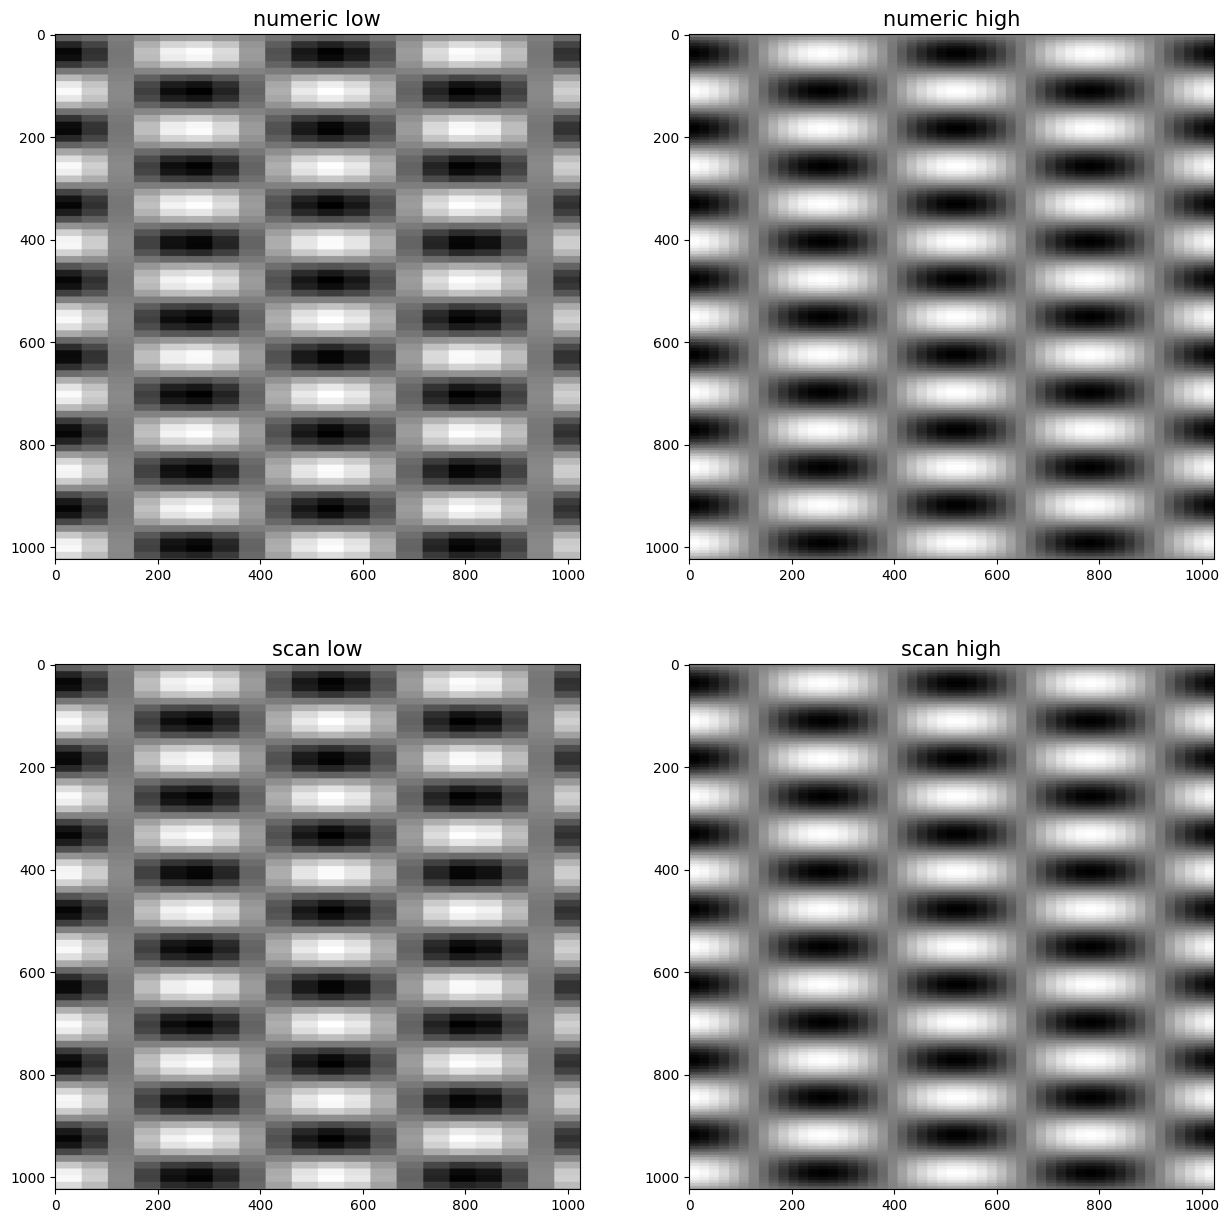

In [14]:
# part g 
scan_low = scan_find_best_bit_allocation(horizontal_der, vertical_der, delta_phi, B_low)
scan_high = scan_find_best_bit_allocation(horizontal_der, vertical_der, delta_phi, B_high)
print("B low:")
print("b = " + str(scan_low[0]) + ",  N_x = " + str(scan_low[1]) + ",  N_y = " + str(scan_low[2]))
print("B high:")
print("b = " + str(scan_high[0]) + ",  N_x = " + str(scan_high[1]) + ",  N_y = " + str(scan_high[2]))

plotimages(numeric_low, numeric_high, scan_low, scan_high)

part c:
Value Range: 4999
Horizontal-Derivative energy: 3021599202
Vertical-Derivative energy: 246695987

part e:
B low:
b = 3,  N_x = 72,  N_y = 23
B high:
b = 5,  N_x = 188,  N_y = 53

part g:
B low:
b = 3,  N_x = 79,  N_y = 21
B high:
b = 5,  N_x = 185,  N_y = 54




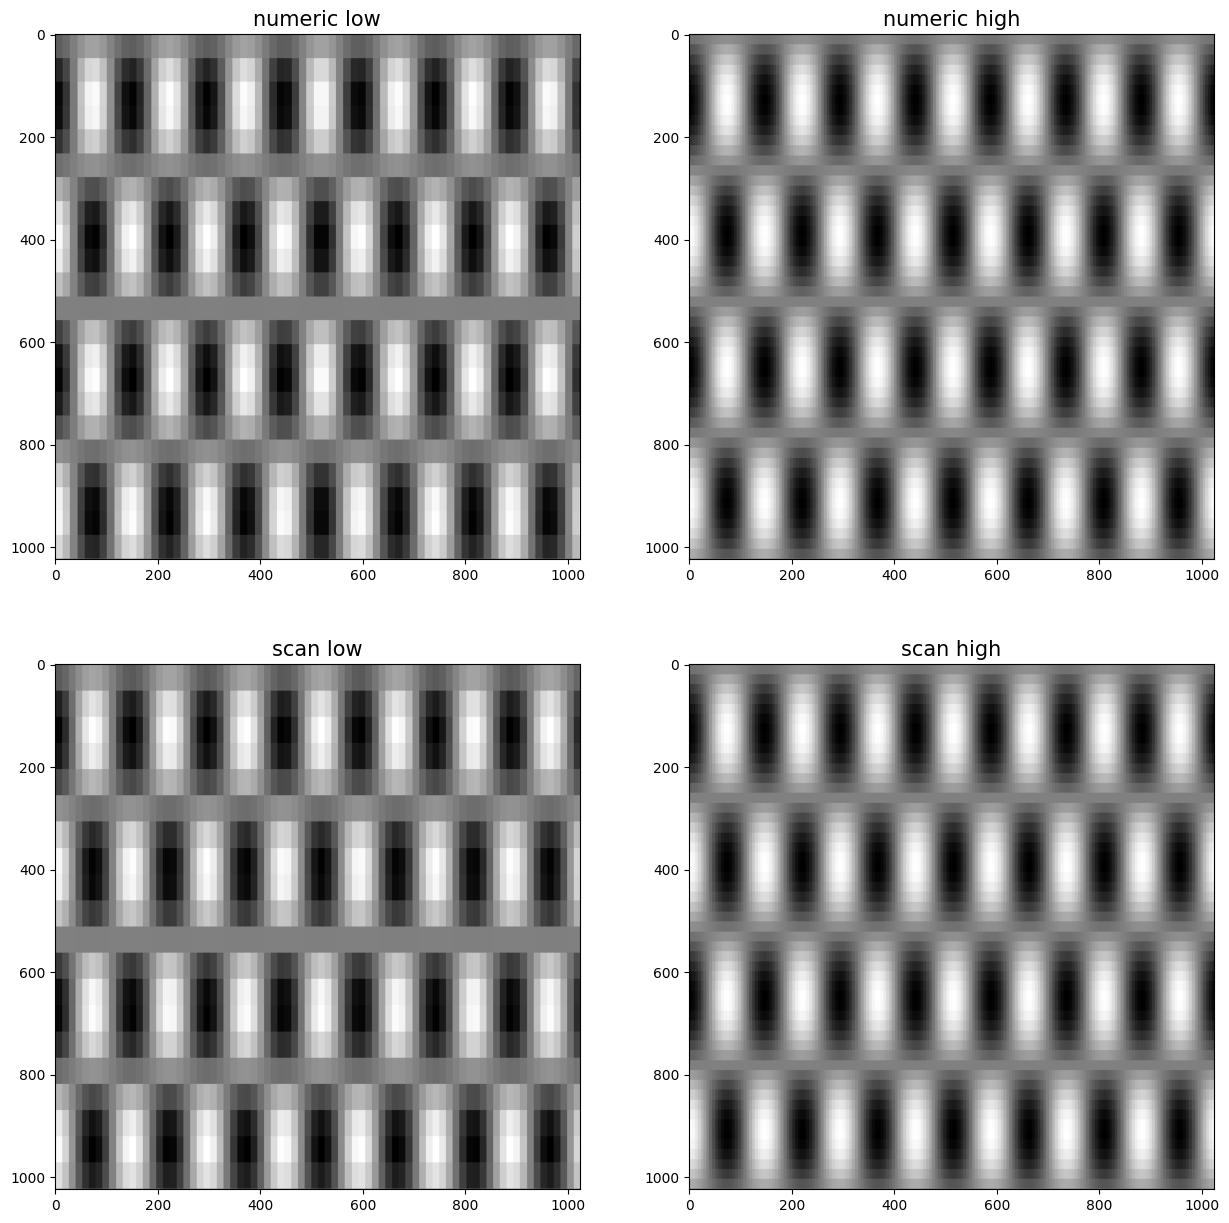

In [15]:
# part h
w_x = 7
w_y = 2

# h_b
image = get_sample_image(sample_size,sample_size)
image_show = ((image/(2*A)) + 0.5).astype("float32")
cv2.imshow('image part b', image_show)
cv2.waitKey()

# h_c
print("part c:")
phi_l, phi_h = np.amin(image),np.amax(image)
horizontal_der, vertical_der = calc_energy(image)
delta_phi = phi_h - phi_l
print("Value Range: "+str(int(delta_phi)))
print("Horizontal-Derivative energy: " + str(int(horizontal_der)))
print("Vertical-Derivative energy: " + str(int(vertical_der)))

# h_e
print()
print("part e:")
numeric_low = get_bit_allocation(horizontal_der, vertical_der, delta_phi, B_low)
numeric_high = get_bit_allocation(horizontal_der, vertical_der, delta_phi, B_high)
print("B low:")
print("b = " + str(numeric_low[0]) + ",  N_x = " + str(numeric_low[1]) + ",  N_y = " + str(numeric_low[2]))
print("B high:")
print("b = " + str(numeric_high[0]) + ",  N_x = " + str(numeric_high[1]) + ",  N_y = " + str(numeric_high[2]))
# h_g 
print()
print("part g:")
scan_low = scan_find_best_bit_allocation(horizontal_der, vertical_der, delta_phi, B_low)
scan_high = scan_find_best_bit_allocation(horizontal_der, vertical_der, delta_phi, B_high)
print("B low:")
print("b = " + str(scan_low[0]) + ",  N_x = " + str(scan_low[1]) + ",  N_y = " + str(scan_low[2]))
print("B high:")
print("b = " + str(scan_high[0]) + ",  N_x = " + str(scan_high[1]) + ",  N_y = " + str(scan_high[2]))
print()
print()
plotimages(numeric_low, numeric_high, scan_low, scan_high)